In [99]:
import torch 
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms 
from torchvision.datasets import Omniglot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px 
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [100]:
augmentation1 = transforms.Compose([
    transforms.RandomResizedCrop(105, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmentation2 = transforms.Compose([
    transforms.RandomResizedCrop(105, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [101]:
class SimSiamOmniglot(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __getitem__(self, index):
        img, _ = self.base_dataset[index]
        view1 = augmentation1(img)
        view2 = augmentation2(img)
        return view1, view2

    def __len__(self):
        return len(self.base_dataset)

In [102]:
class Encoder(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        mobilenet = models.mobilenet_v2(pretrained=False)
        mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1280, out_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [103]:
class MLP(nn.Module):
    def __init__(self, in_dim=128, proj_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, proj_dim)
        )

    def forward(self, x):
        return self.mlp(x)

In [104]:
def simsiam_loss(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return - (p * z.detach()).sum(dim=1).mean()

In [105]:
def identity(x):
    return x

In [106]:
omniglot_train = Omniglot(root='./data', background=True, download=True, transform=identity)
simsiam_dataset = SimSiamOmniglot(omniglot_train)
loader = DataLoader(simsiam_dataset, batch_size=64, shuffle=True,drop_last=True)

Files already downloaded and verified


In [107]:
len(loader)

301

In [108]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [109]:
encoder = Encoder().to(device)
projector = MLP().to(device)
predictor = MLP().to(device)

In [110]:
optimizer = Adam(list(encoder.parameters()) + list(projector.parameters()) + list(predictor.parameters()), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [111]:
loss_history = []

for epoch in range(1, 101): 
    encoder.train()
    projector.train()
    predictor.train()
    total_loss = 0

    loop = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for view1, view2 in loop:
        view1, view2 = view1.to(device), view2.to(device)

        h1 = encoder(view1)
        z1 = projector(h1)
        p1 = predictor(z1)

        h2 = encoder(view2)
        z2 = projector(h2)
        p2 = predictor(z2)

        loss = 0.5 * (simsiam_loss(p1, z2) + simsiam_loss(p2, z1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch} | Avg Loss: {avg_loss:.4f}")

    scheduler.step(avg_loss)


Epoch 1 | Avg Loss: -0.2068


Epoch 2 | Avg Loss: -0.3586


Epoch 3 | Avg Loss: -0.5004


Epoch 4 | Avg Loss: -0.6076


Epoch 5 | Avg Loss: -0.6939


Epoch 6 | Avg Loss: -0.7638


Epoch 7 | Avg Loss: -0.8201


Epoch 8 | Avg Loss: -0.8642


Epoch 9 | Avg Loss: -0.8987


Epoch 10 | Avg Loss: -0.9256


Epoch 11 | Avg Loss: -0.9466


Epoch 12 | Avg Loss: -0.9628


Epoch 13 | Avg Loss: -0.9747


Epoch 14 | Avg Loss: -0.9833


Epoch 15 | Avg Loss: -0.9894


Epoch 16 | Avg Loss: -0.9935


Epoch 17 | Avg Loss: -0.9961


Epoch 18 | Avg Loss: -0.9975


Epoch 19 | Avg Loss: -0.9982


Epoch 20 | Avg Loss: -0.9985


Epoch 21 | Avg Loss: -0.9987


Epoch 22 | Avg Loss: -0.9988


Epoch 23 | Avg Loss: -0.9989


KeyboardInterrupt: 

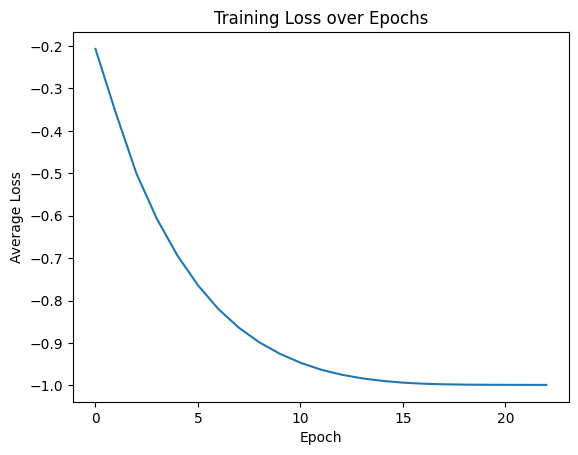

In [112]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [113]:
torch.save(encoder.state_dict(), 'simsiam_encoder.pth')
print("Encoder saved to simsiam_encoder.pth")

Encoder saved to simsiam_encoder.pth
